The easiest way to download data is using the official [Kaggle cli](https://github.com/Kaggle/kaggle-api). If you don't have it installed yet, I would recommend setting it up. It will not only make downloading data a breeze, but we also will be needing it to make submissions.

The data is a 7GB zip file that will be downloaded to the root of the repository.

In [1]:
!kaggle competitions download -c freesound-audio-tagging

100%|█████████████████████████████████████▉| 7.06G/7.07G [11:52<00:00, 10.9MB/s]
100%|██████████████████████████████████████| 7.07G/7.07G [11:52<00:00, 10.6MB/s]


In [3]:
mkdir data

In [5]:
!unzip freesound-audio-tagging.zip -d data

Archive:  freesound-audio-tagging.zip
  inflating: data/audio_test.zip     
  inflating: data/test_post_competition.csv  
  inflating: data/sample_submission.csv  
  inflating: data/train_post_competition.csv  
  inflating: data/audio_train.zip    
  inflating: data/train.csv          


In [6]:
import pandas as pd

In [7]:
sub = pd.read_csv('data/sample_submission.csv')
sub.head()

,fname,label
0,00063640.wav,Laughter Hi-Hat Flute
1,0013a1db.wav,Laughter Hi-Hat Flute
2,002bb878.wav,Laughter Hi-Hat Flute
3,002d392d.wav,Laughter Hi-Hat Flute
4,00326aa9.wav,Laughter Hi-Hat Flute


In [8]:
sub.shape

(9400, 2)

The submission file has a simple structure - filenames along with space seperated predicted classes. This is something that we will work towards generating.

The evaluation metric is mean average precision @3. Here is [an implementation](https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py) of the metric in Python.

In [10]:
trn = pd.read_csv('data/train.csv')

In [11]:
trn.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [12]:
trn.shape

(9473, 3)

Not a whole lot of files in the training set - this is perfect. Just what we need to iterate quickly on our experiments.

The labels are noisy (hence the `manually_verified` column.

In [13]:
trn.manually_verified.value_counts()

0    5763
1    3710
Name: manually_verified, dtype: int64

Another consideration is that the classes are not balanced.

In [14]:
trn.label.value_counts()

Clarinet                 300
Applause                 300
Saxophone                300
Hi-hat                   300
Flute                    300
Trumpet                  300
Fart                     300
Squeak                   300
Double_bass              300
Violin_or_fiddle         300
Tearing                  300
Bass_drum                300
Fireworks                300
Acoustic_guitar          300
Cello                    300
Shatter                  300
Laughter                 300
Snare_drum               300
Oboe                     299
Gong                     292
Knock                    279
Writing                  270
Cough                    243
Bark                     239
Tambourine               221
Burping_or_eructation    210
Cowbell                  191
Harmonica                165
Drawer_open_or_close     158
Meow                     155
Electric_piano           150
Gunshot_or_gunfire       147
Microwave_oven           146
Keys_jangling            139
Telephone     

Let's extract the data

In [23]:
%%capture
!unzip data/audio_train.zip -d data
!unzip data/audio_test.zip -d data

Verifying file count vs what we have in csvs

In [28]:
!ls -l data/audio_test | wc -l 
!ls -l data/audio_train | wc -l 

9401
9474


Let's look at the data

In [29]:
import librosa
from scipy.io import wavfile

In [39]:
x, sr = librosa.core.load('data/audio_train/5fca79da.wav', sr=None); sr, x

(44100, array([ 0.0000000e+00, -3.0517578e-05, -3.0517578e-05, ...,
        -3.0517578e-05, -6.1035156e-05, -3.0517578e-05], dtype=float32))

The audio was sampled with an SR of 44100, that is probably more than we will need initially. The signal as returned by librosa.core.load consists of values ranging from -1 to 1.

In [40]:
x.max(), x.min()

(0.75979614, -0.7696228)

Let's listen to the recording

In [41]:
from IPython.display import Audio

In [42]:
Audio(x, rate=sr)

I have no clue what that was.

In [45]:
trn[trn.fname == '5fca79da.wav']

,fname,label,manually_verified
3560,5fca79da.wav,Fireworks,0


Fireworks, makes sense. The most telling part doesn't occur at the beginning of the sample, this is something worth taking a note of.

Let's see what the sampling rates and durations of the other files in the dataset are.

In [46]:
from pathlib import Path

In [63]:
%%time

trn_srs = []
trn_lengths = []

for path in Path('data/audio_train').iterdir():
    x, sr = librosa.core.load(path, sr=None)
    trn_srs.append(sr)
    trn_lengths.append(x.shape[0] / sr)
    
tst_srs = []
tst_lengths = []

for path in Path('data/audio_test').iterdir():
    x, sr = librosa.core.load(path, sr=None)
    tst_srs.append(sr)
    tst_lengths.append(x.shape[0] / sr)

CPU times: user 10.7 s, sys: 5.5 s, total: 16.2 s
Wall time: 39.4 s


In [66]:
import numpy as np

In [69]:
np.all(np.array(trn_srs) == 44100), np.all(np.array(tst_srs) == 44100)

(True, True)

The sampling rates of all the files are the same, 44100.

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

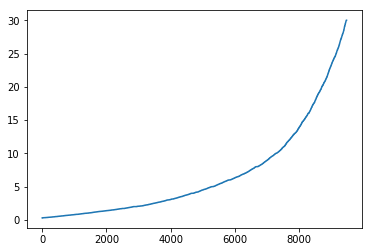

In [73]:
plt.plot(sorted(trn_lengths))

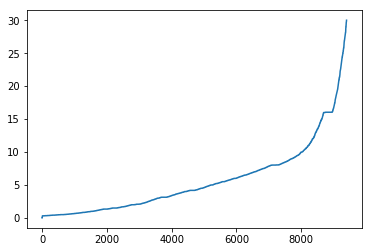

In [74]:
plt.plot(sorted(tst_lengths))

The file lengths are not uniform. This is another thing we will need to address one way or another.

Equipped with this knowledge, we can start working on our first model.